In [1]:
import os
import datetime
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_ocr
import sklearn.model_selection
from fontTools.ttLib import TTFont

2024-10-01 01:11:28.919864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 01:11:29.091427: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Установка директории с данными
data_dir = 'text'

# Алфавит якутского языка
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһү '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

# Пути к файлам данных
wordlist_file = os.path.join(data_dir, 'sah.wordlist')
fonts_list_file = os.path.join(data_dir, 'okfonts_test.txt')
fonts_dir = os.path.join(data_dir, 'fonts')

In [3]:
# Загрузка списка слов из файла wordlist_file
with open(wordlist_file, 'r', encoding='utf-8') as f:
    word_list = [line.strip() for line in f if line.strip()]

# Создание генератора текста
def get_text_generator(words):
    while True:
        random.shuffle(words)
        for word in words:
            yield word

train_text_generator = get_text_generator(word_list)
val_text_generator = get_text_generator(word_list)
test_text_generator = get_text_generator(word_list)

In [4]:
# Загрузка списка директорий шрифтов из файла fonts_list_file
with open(fonts_list_file, 'r', encoding='utf-8') as f:
    font_dir_names = [line.strip() for line in f if line.strip()]
    
font_paths = []

# Проходим по каждой директории и собираем файлы шрифтов
for font_dir_name in font_dir_names:
    font_dir_path = os.path.join(fonts_dir, font_dir_name)
    if not os.path.isdir(font_dir_path):
        print(f"Директория {font_dir_path} не найдена. Пропускаем её.")
        continue
    # Рекурсивно ищем файлы шрифтов в директории font_dir_path
    for root, dirs, files in os.walk(font_dir_path):
        for fname in files:
            if fname.lower().endswith(('.ttf', '.otf')):
                font_path = os.path.join(root, fname)
                font_paths.append(font_path)

# Вывод количества найденных шрифтов
print(f"Количество найденных файлов шрифтов: {len(font_paths)}")

Количество найденных файлов шрифтов: 75


In [5]:
# Разделение данных на тренировочные, валидационные и тестовые наборы
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

# Разделение шрифтов
train_fonts, val_fonts, test_fonts = get_train_val_test_split(font_paths)

In [6]:
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)
train_backgrounds, val_backgrounds, test_backgrounds = get_train_val_test_split(backgrounds)

Looking for text/backgrounds.zip


In [11]:
def get_fonts_supporting_char(char, fonts):
    supporting_fonts = []
    for font_path in fonts:
        try:
            font = TTFont(font_path)
            cmap = font.getBestCmap()
            if ord(char) in cmap:
                supporting_fonts.append(font_path)
        except Exception as e:
            print(f"Ошибка при обработке шрифта {font_path}: {e}")
    return supporting_fonts

train_font_groups = {char: get_fonts_supporting_char(char, train_fonts) for char in recognizer_alphabet}
val_font_groups = {char: get_fonts_supporting_char(char, val_fonts) for char in recognizer_alphabet}

In [12]:
# Создание генераторов изображений
train_image_generator = keras_ocr.data_generation.get_image_generator(
    height=640,
    width=640,
    text_generator=train_text_generator,
    font_groups=train_font_groups,
    backgrounds=train_backgrounds,
    font_size=(60, 120),
    margin=50,
    rotationX=(-0.05, 0.05),
    rotationY=(-0.05, 0.05),
    rotationZ=(-15, 15)
)

val_image_generator = keras_ocr.data_generation.get_image_generator(
    height=640,
    width=640,
    text_generator=val_text_generator,
    font_groups=val_font_groups,
    backgrounds=val_backgrounds,
    font_size=(60, 120),
    margin=50,
    rotationX=(-0.05, 0.05),
    rotationY=(-0.05, 0.05),
    rotationZ=(-15, 15)
)

Первое сгенерированное тренировочное изображение содержит текст: му
льтсери
ал


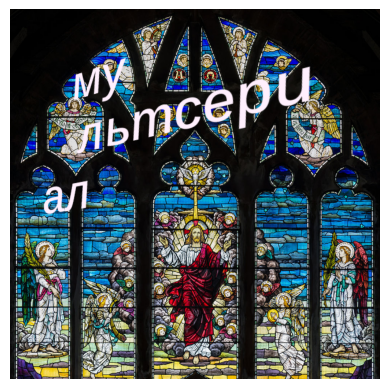

In [13]:
image, lines = next(train_image_generator)
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('Первое сгенерированное тренировочное изображение содержит текст:', text)
plt.imshow(image)
plt.axis('off')
plt.show()

In [28]:
from keras_ocr import losses


ImportError: cannot import name 'losses' from 'keras_ocr' (/usr/local/lib/python3.8/dist-packages/keras_ocr/__init__.py)

In [30]:
# Создание детектора
detector = keras_ocr.detection.Detector(weights='clovaai_general')

# Компиляция модели детектора
detector.model.compile(
    optimizer='adam',
    loss="mse"
)

detector_batch_size = 8

# Создание генераторов батчей для детектора
detection_train_generator = detector.get_batch_generator(
    image_generator=train_image_generator,
    batch_size=detector_batch_size
)

detection_val_generator = detector.get_batch_generator(
    image_generator=val_image_generator,
    batch_size=detector_batch_size
)

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [24]:
images, boxes = next(detection_train_generator)
print(f"Размер батча изображений: {images.shape}")
print(f"Количество меток: {len(boxes)}")

Размер батча изображений: (8, 640, 640, 3)
Количество меток: 8


In [31]:
train_steps_detector = 100
val_steps_detector = 20

# Обучение детектора
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=train_steps_detector,
    epochs=1,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=val_steps_detector,
    batch_size=detector_batch_size
)

Epoch 1/10


2024-10-01 01:59:33.720826: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-10-01 01:59:35.672565: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


104/104 [==============================] - 203s 2s/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2/10
104/104 [==============================] - 155s 1s/step - loss: 7.1434e-04 - val_loss: 9.3902e-04
Epoch 3/10
 13/104 [==>...........................] - ETA: 2:02 - loss: 6.6363e-04

2024-10-01 02:05:47.183048: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 700, in get_image_generator
    text_image, lines = draw_text_image(

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 387, in draw_text_image
    character_font_pairs = [

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 390, in <listcomp>
    next(

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/di

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 700, in get_image_generator
    text_image, lines = draw_text_image(

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 387, in draw_text_image
    character_font_pairs = [

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 390, in <listcomp>
    next(

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.8/dist-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/detection.py", line 722, in get_batch_generator
    batch = [next(image_generator) for n in range(batch_size)]

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/detection.py", line 722, in <listcomp>
    batch = [next(image_generator) for n in range(batch_size)]

RuntimeError: generator raised StopIteration


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_12]]
  (1) UNKNOWN:  RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 700, in get_image_generator
    text_image, lines = draw_text_image(

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 387, in draw_text_image
    character_font_pairs = [

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/data_generation.py", line 390, in <listcomp>
    next(

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.8/dist-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/detection.py", line 722, in get_batch_generator
    batch = [next(image_generator) for n in range(batch_size)]

  File "/usr/local/lib/python3.8/dist-packages/keras_ocr/detection.py", line 722, in <listcomp>
    batch = [next(image_generator) for n in range(batch_size)]

RuntimeError: generator raised StopIteration


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_27188]